# 2023C2: Plotting SST1 RSoXS Data

## Imports

In [ ]:
!pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory

In [1]:
## Imports
import PyHyperScattering as phs
import pathlib
import sys
import io
import ast
import json
import datetime
import dask.array as da
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.auto import tqdm
import dask.array as da
from tiled.client import from_profile, from_uri
import subprocess


print(f'Using PyHyperScattering Version: {phs.__version__}')

/nsls2/users/alevin/repos/PyHyperScattering/src/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator


Using PyHyperScattering Version: 0.2.1+37.gac1f562


In [22]:
sorted([f.name for f in zarrsPath.glob('TRMSN*nexafs*')])

['TRMSN_nexafs_carbon_3angle.zarr',
 'TRMSN_nexafs_carbon_day1.zarr',
 'TRMSN_nexafs_nitrogen_3angle.zarr',
 'TRMSN_nexafs_nitrogen_day1.zarr']

In [23]:
trmsn_4angle = xr.open_zarr(zarrsPath.joinpath('TRMSN_nexafs_nitrogen_day1.zarr'))
trmsn_3angle = xr.open_zarr(zarrsPath.joinpath('TRMSN_nexafs_nitrogen_3angle.zarr'))

trmsn_90_part1 = trmsn_4angle.sel(theta=90)
trmsn_90_part2 = trmsn_3angle.sel(theta=90)

trmsn90 = xr.concat([trmsn_90_part1, trmsn_90_part2], dim='sample_name')
trmsn90

<xarray.Dataset>
Dimensions:          (sample_name: 44, energy: 2000)
Coordinates:
  * energy           (energy) float64 370.0 370.0 370.1 ... 439.9 440.0 440.0
    sample_id        (sample_name) <U12 dask.array<chunksize=(21,), meta=np.ndarray>
  * sample_name      (sample_name) object 'BareSiN_1p5mm_rot' ... 'PM6-Y6BO_C...
    scan_id          (sample_name) int64 dask.array<chunksize=(21,), meta=np.ndarray>
    theta            int64 90
Data variables:
    calib_au_mesh    (sample_name, energy) float64 dask.array<chunksize=(21, 2000), meta=np.ndarray>
    calib_diode      (sample_name, energy) float64 dask.array<chunksize=(21, 2000), meta=np.ndarray>
    dnorm_trmsn      (energy, sample_name) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    full_corr_trmsn  (sample_name, energy) float64 dask.array<chunksize=(11, 2000), meta=np.ndarray>
    pre_corr_trmsn   (sample_name, energy) float64 dask.array<chunksize=(11, 2000), meta=np.ndarray>
    raw_trmsn        (energy, sample_name) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sample_au_mesh   (energy, sample_name) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
Attributes:
    name:     nexafs_nitrogen

In [29]:
# polar_netcdf_paths = str(zarrsPath.joinpath('polar_rsoxs_carbon_ncs')) + '/*.nc'
# polar_netcdf_paths

In [30]:
# # rsoxs_datasets = {}
# # rsoxs_datasets['polar_carbon'] = xr.open_mfdataset(polar_netcdf_paths, parallel=True)
# rsoxs_datasets['polar_carbon'] = xr.open_mfdataset(polar_netcdf_paths)
# rsoxs_datasets['polar_carbon']

In [26]:
trmsn90_sample_names = []
for sample_name in trmsn90.sample_name.values:
    trmsn90_sample_names.append(sample_name.replace('_rot', ''))
    
display(trmsn90_sample_names)

['BareSiN_1p5mm',
 'Y6_CB_2500',
 'Y6_CF_2500',
 'Y6BO_CB_2500',
 'Y6BO_CF_2500',
 'Y7_CB_2000',
 'Y7_CF_2500',
 'Y7BO_CB_2500',
 'Y6_CB_2000',
 'Y6_CB_3000',
 'Y6_CF_2000',
 'Y6BO_CB_3000',
 'Y7_CF_2000',
 'Y7_CF_3000',
 'Y7BO_CB_2000',
 'Y7BO_CB_3000',
 'Y7BO_CF_2000',
 'Y7BO_CF_2500',
 'Y7BO_CF_3000',
 'Y6_CBCN',
 'Y6BO_CBCN',
 'Y7_CBCN',
 'Y7BO_CBCN',
 'PM6-Y6_CB',
 'PM6-Y6BO_CB',
 'PM6-Y7_CB',
 'PM6-Y7BO_CB',
 'PM6-Y6_CBCN',
 'PM6-Y7_CBCN',
 'PM6-Y7BO_CBCN',
 'Y6_CFCN',
 'Y6BO_CFCN',
 'Y7_CFCN',
 'Y7BO_CFCN',
 'PM6-Y6_CF',
 'PM6-Y7BO_CF',
 'PM6-Y6_CFCN',
 'PM6-Y6BO_CFCN',
 'PM6-Y7_CFCN',
 'BareSiN_1mm',
 'BareSiN_1mm_1',
 'PM6-Y7_CF',
 'PM6-Y7BO_CFCN',
 'PM6-Y6BO_CF']

In [27]:
bad_trmsn_samples = ['Y6_CBCN', 'Y6BO_CBCN', 'Y6BO_CFCN','Y7_CB_2000', 'Y7_CB_2000_1', 'Y7_CBCN', 'Y7_CFCN', 
                     'Y7BO_CFCN', 'BareSiN_1p5mm', 'BareSiN_1mm', 'BareSiN_1mm_1', 'BareSiN_1mm_2']

In [29]:
selected_samples = [sample_name for sample_name in rsoxs_datasets['polar_nitrogen'].sample_name.values if sample_name not in bad_trmsn_samples]
selected_samples

['Y6_CB_2500',
 'Y6_CF_2500',
 'Y6BO_CB_2500',
 'Y6BO_CF_2500',
 'Y7_CF_2500',
 'Y7BO_CB_2500',
 'Y6_CB_2000',
 'Y6_CB_3000',
 'Y6_CF_2000',
 'Y6BO_CB_3000',
 'Y7_CF_2000',
 'Y7_CF_3000',
 'Y7BO_CB_2000',
 'Y7BO_CB_3000',
 'Y7BO_CF_2000',
 'Y7BO_CF_2500',
 'Y7BO_CF_3000',
 'Y7BO_CBCN',
 'PM6-Y6_CB',
 'PM6-Y6BO_CB',
 'PM6-Y7_CB',
 'PM6-Y7BO_CB',
 'PM6-Y6_CBCN',
 'PM6-Y7_CBCN',
 'PM6-Y7BO_CBCN',
 'Y6_CFCN',
 'PM6-Y6_CF',
 'PM6-Y6BO_CF',
 'PM6-Y7_CF',
 'PM6-Y7BO_CF',
 'PM6-Y6_CFCN',
 'PM6-Y6BO_CFCN',
 'PM6-Y7_CFCN',
 'PM6-Y7BO_CFCN',
 'Y6_CB_2000_1']

In [37]:
for sample_name in selected_samples:
    print(sample_name)
    sample_name = sample_name.replace('_1', '')
    print(sample_name in trmsn90_sample_names)
    print('\n')

Y6_CB_2500
True


Y6_CF_2500
True


Y6BO_CB_2500
True


Y6BO_CF_2500
True


Y7_CF_2500
True


Y7BO_CB_2500
True


Y6_CB_2000
True


Y6_CB_3000
True


Y6_CF_2000
True


Y6BO_CB_3000
True


Y7_CF_2000
True


Y7_CF_3000
True


Y7BO_CB_2000
True


Y7BO_CB_3000
True


Y7BO_CF_2000
True


Y7BO_CF_2500
True


Y7BO_CF_3000
True


Y7BO_CBCN
True


PM6-Y6_CB
True


PM6-Y6BO_CB
True


PM6-Y7_CB
True


PM6-Y7BO_CB
True


PM6-Y6_CBCN
True


PM6-Y7_CBCN
True


PM6-Y7BO_CBCN
True


Y6_CFCN
True


PM6-Y6_CF
True


PM6-Y6BO_CF
True


PM6-Y7_CF
True


PM6-Y7BO_CF
True


PM6-Y6_CFCN
True


PM6-Y6BO_CFCN
True


PM6-Y7_CFCN
True


PM6-Y7BO_CFCN
True


Y6_CB_2000_1
True




In [39]:
selected_samples

['Y6_CB_2500',
 'Y6_CF_2500',
 'Y6BO_CB_2500',
 'Y6BO_CF_2500',
 'Y7_CF_2500',
 'Y7BO_CB_2500',
 'Y6_CB_2000',
 'Y6_CB_3000',
 'Y6_CF_2000',
 'Y6BO_CB_3000',
 'Y7_CF_2000',
 'Y7_CF_3000',
 'Y7BO_CB_2000',
 'Y7BO_CB_3000',
 'Y7BO_CF_2000',
 'Y7BO_CF_2500',
 'Y7BO_CF_3000',
 'Y7BO_CBCN',
 'PM6-Y6_CB',
 'PM6-Y6BO_CB',
 'PM6-Y7_CB',
 'PM6-Y7BO_CB',
 'PM6-Y6_CBCN',
 'PM6-Y7_CBCN',
 'PM6-Y7BO_CBCN',
 'Y6_CFCN',
 'PM6-Y6_CF',
 'PM6-Y6BO_CF',
 'PM6-Y7_CF',
 'PM6-Y7BO_CF',
 'PM6-Y6_CFCN',
 'PM6-Y6BO_CFCN',
 'PM6-Y7_CFCN',
 'PM6-Y7BO_CFCN',
 'Y6_CB_2000_1']

In [35]:
filtered_selected_samples = selected_samples[:19] + selected_samples[22:26] + selected_samples[27:29]
filtered_selected_samples

['Y6_CB_2500',
 'Y6_CF_2500',
 'Y6BO_CB_2500',
 'Y6BO_CF_2500',
 'Y7_CF_2500',
 'Y7BO_CB_2500',
 'Y6_CB_2000',
 'Y6_CB_3000',
 'Y6_CF_2000',
 'Y6BO_CB_3000',
 'Y7_CF_2000',
 'Y7_CF_3000',
 'Y7BO_CB_2000',
 'Y7BO_CB_3000',
 'Y7BO_CF_2000',
 'Y7BO_CF_2500',
 'Y7BO_CF_3000',
 'Y7BO_CBCN',
 'PM6-Y6_CB',
 'PM6-Y6_CBCN',
 'PM6-Y7_CBCN',
 'PM6-Y7BO_CBCN',
 'Y6_CFCN',
 'PM6-Y6BO_CF',
 'PM6-Y7_CF']

In [42]:
trmsn90

<xarray.Dataset>
Dimensions:          (sample_name: 44, energy: 2000)
Coordinates:
  * energy           (energy) float64 370.0 370.0 370.1 ... 439.9 440.0 440.0
    sample_id        (sample_name) <U12 dask.array<chunksize=(21,), meta=np.ndarray>
  * sample_name      (sample_name) object 'BareSiN_1p5mm_rot' ... 'PM6-Y6BO_C...
    scan_id          (sample_name) int64 dask.array<chunksize=(21,), meta=np.ndarray>
    theta            int64 90
Data variables:
    calib_au_mesh    (sample_name, energy) float64 dask.array<chunksize=(21, 2000), meta=np.ndarray>
    calib_diode      (sample_name, energy) float64 dask.array<chunksize=(21, 2000), meta=np.ndarray>
    dnorm_trmsn      (energy, sample_name) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    full_corr_trmsn  (sample_name, energy) float64 dask.array<chunksize=(11, 2000), meta=np.ndarray>
    pre_corr_trmsn   (sample_name, energy) float64 dask.array<chunksize=(11, 2000), meta=np.ndarray>
    raw_trmsn        (energy, sample_name) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
    sample_au_mesh   (energy, sample_name) float64 dask.array<chunksize=(1000, 21), meta=np.ndarray>
Attributes:
    name:     nexafs_nitrogen

In [47]:
# trmsn90_DA = trmsn90['full_corr_trmsn']
trmsn90_DA = trmsn90['pre_corr_trmsn'] / trmsn90['pre_corr_trmsn'].sel(energy=slice(430,440)).mean('energy')
# pre_edge_mean = trmsn90_DA.sel(energy=slice(270,280)).mean('energy')
# trmsn90_DA = (trmsn90_DA - pre_edge_mean) * -1

trmsn90_DA

<xarray.DataArray 'pre_corr_trmsn' (sample_name: 44, energy: 2000)>
dask.array<truediv, shape=(44, 2000), dtype=float64, chunksize=(12, 2000), chunktype=numpy.ndarray>
Coordinates:
  * energy       (energy) float64 370.0 370.0 370.1 370.1 ... 439.9 440.0 440.0
    sample_id    (sample_name) <U12 dask.array<chunksize=(21,), meta=np.ndarray>
  * sample_name  (sample_name) object 'BareSiN_1p5mm_rot' ... 'PM6-Y6BO_CF_rot'
    scan_id      (sample_name) int64 dask.array<chunksize=(21,), meta=np.ndarray>
    theta        int64 90

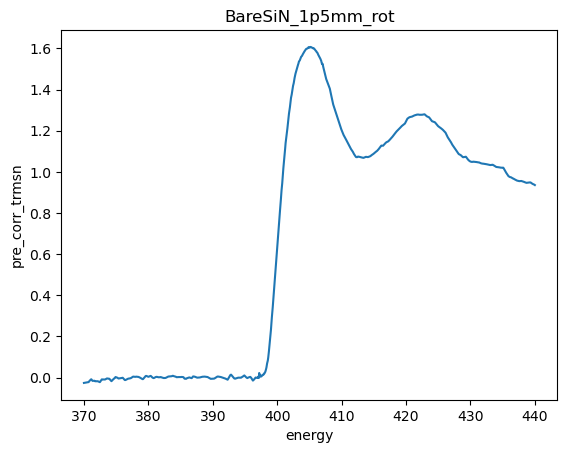

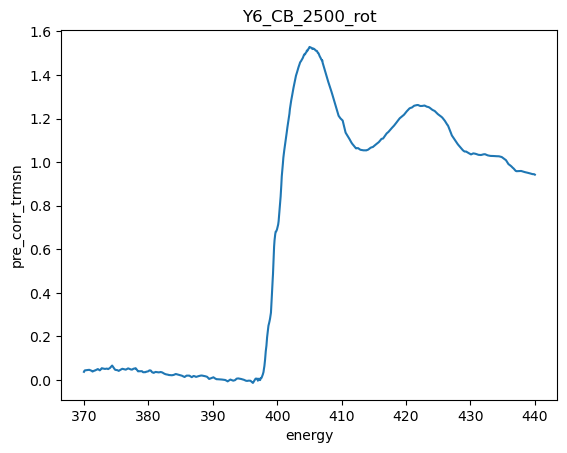

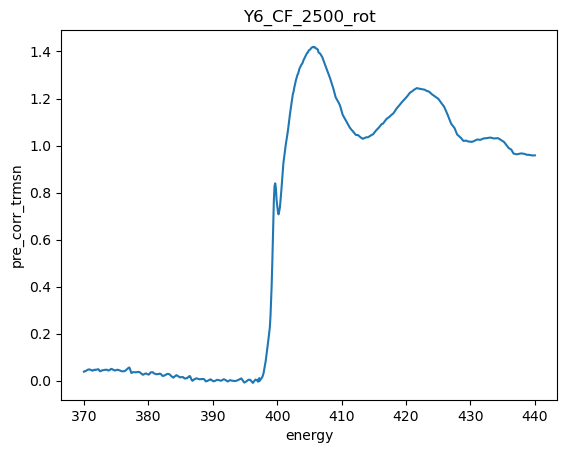

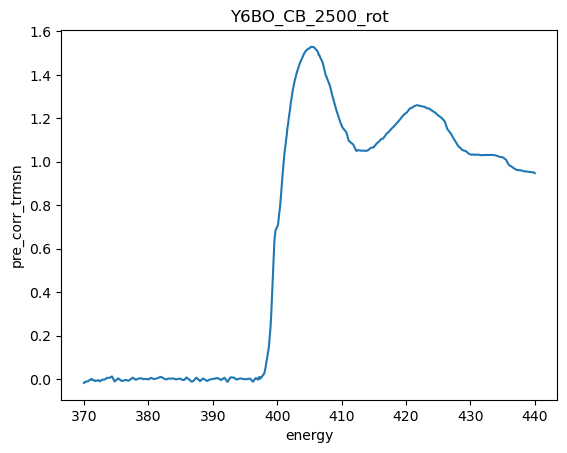

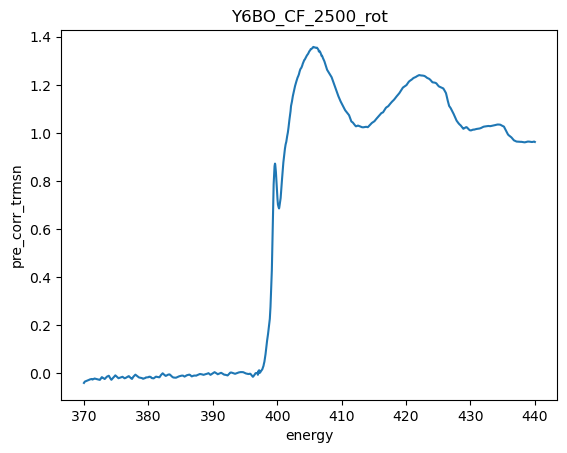

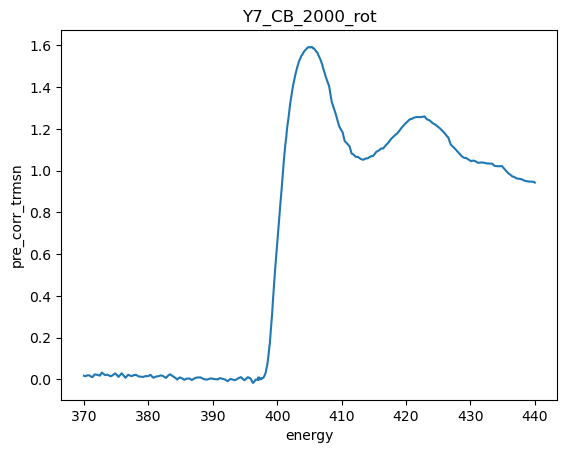

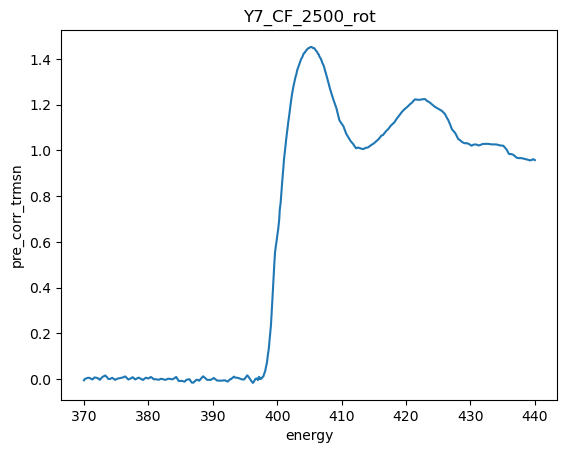

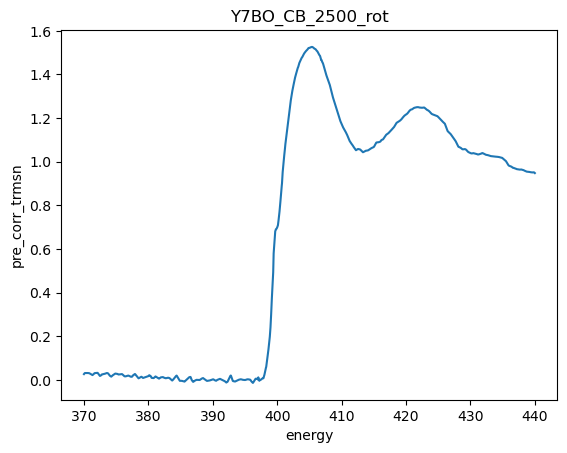

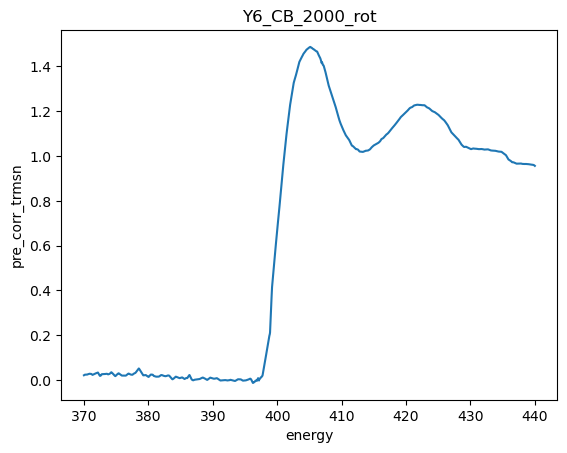

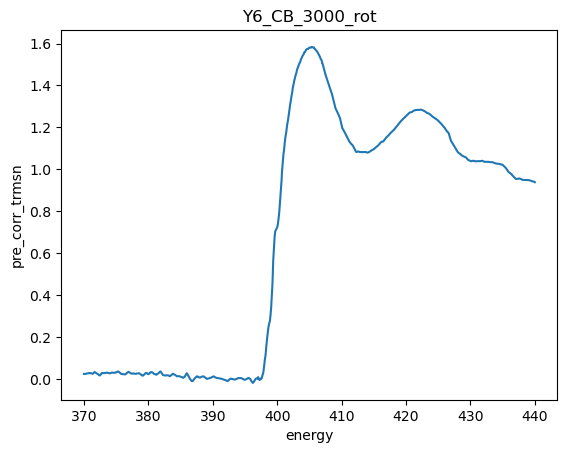


KeyboardInterrupt



In [48]:
for sample_name in trmsn90_DA.sample_name.values:
    # trmsn90_DA = trmsn90['pre_corr_trmsn'] / trmsn90['pre_corr_trmsn'].sel(energy=slice(430,440)).mean('energy')
    trmsn90_DA.sel(sample_name=sample_name).plot()
    plt.title(sample_name)
    plt.show()

In [50]:
polar_DS = rsoxs_datasets['polar_nitrogen']
trmsn90_DA = trmsn90_DA.interp({'energy': polar_DS.energy.values})
# polar_DS

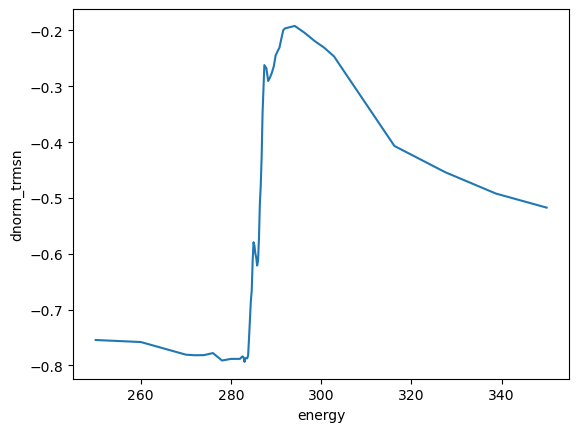

In [103]:
trmsn90_samp_DA.drop_vars(['sample_id', 'sample_name', 'theta', 'scan_id'])

In [228]:
fl_bkgs = []
trmsn90_bkgs = []

for sample_name in tqdm(selected_samples):
    polar_samp_DA = polar_DS['corr_intensity'].sel(sample_name=sample_name)
    fl_bkg_DA = 1 * polar_samp_DA.sel(polarization=0,q=slice(0.02, 0.06)).mean('chi').integrate('q')
    fl_bkgs.append(fl_bkg_DA)
    # fl_bkg_DA.plot()
    # plt.show()
    
    trmsn90_samp_DA = trmsn90_DA.sel(sample_name=(sample_name.replace('_1','')+'_rot')).drop_vars(['sample_id', 'sample_name', 'theta', 'scan_id'])
    trmsn90_samp_DA = trmsn90_samp_DA.expand_dims({'sample_name':[sample_name]})
    trmsn90_bkgs.append(trmsn90_samp_DA)
#     trmsn90_samp_DA.plot()
#     plt.show()
    
#     plt.close('all')
        

  0%|          | 0/39 [00:00<?, ?it/s]

## Define Paths

In [15]:
def make_para_perp_DAs(datasets, sample_name, edge, intensity_type, pol, qlims, chi_width):
    # select dataarray to plot
    DS = datasets[f'polar_{edge}']
    DA = DS.sel(sample_name=sample_name)[f'{intensity_type}_intensity']
    sliced_DA = DA.sel(polarization=pol, q=slice(qlims[0],qlims[1]))

    # calculate ISI dataarrays
    if pol==0:
        para_DA = sliced_DA.rsoxs.slice_chi(180, chi_width=(chi_width/2))
        perp_DA = sliced_DA.rsoxs.slice_chi(90, chi_width=(chi_width/2))
    elif pol==90:
        perp_DA = sliced_DA.rsoxs.slice_chi(180, chi_width=(chi_width/2))
        para_DA = sliced_DA.rsoxs.slice_chi(90, chi_width=(chi_width/2))   
        
    return para_DA, perp_DA

In [2]:
def make_para_perp_DAs(DS, sample_name, intensity_type, pol, qlims, chi_width):
    # select dataarray to plot
    # DS = datasets[f'polar_{edge}']
    DA = DS.sel(sample_name=sample_name)[f'{intensity_type}_intensity']
    sliced_DA = DA.sel(polarization=pol, q=slice(qlims[0],qlims[1]))

    # calculate ISI dataarrays
    if pol==0:
        para_DA = sliced_DA.rsoxs.slice_chi(180, chi_width=(chi_width/2))
        perp_DA = sliced_DA.rsoxs.slice_chi(90, chi_width=(chi_width/2))
    elif pol==90:
        perp_DA = sliced_DA.rsoxs.slice_chi(180, chi_width=(chi_width/2))
        para_DA = sliced_DA.rsoxs.slice_chi(90, chi_width=(chi_width/2))   
        
    return para_DA, perp_DA

In [3]:
## Define directory paths
userPath = pathlib.Path('/nsls2/users/alevin')
propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-3/pass-313412')

outPath = propPath.joinpath('processed_data')
plotsPath = outPath.joinpath('prsoxs_plots')
# jsonPath = outPath.joinpath('local_config')
maskPath = outPath.joinpath('masks')
zarrsPath = outPath.joinpath('zarrs')


# propPath = pathlib.Path('/nsls2/data/sst/proposals/2022-2/pass-309180')
# zarrsPath = propPath.joinpath('zarr_datasets_jul2022')
# outPath = propPath.joinpath('processed_data')
# plotsPath = outPath.joinpath('prsoxs_plots')

## Load DataArrays 

In [10]:
# load dictionary of rsoxs datasets
rsoxs_datasets = {}
for key in ['cartesian_nitrogen', 'polar_nitrogen']:
    key_start = key.split('_')[0]
    key_end = key.split('_')[1]        
    zarrPath = list(zarrsPath.glob(f'{key_start}*{key_end}_rechunked-v1.zarr'))[0]
    rsoxs_datasets[key] = xr.open_zarr(zarrPath)
    
    # Compute any dask coordiantes
    for coord_name, coord_data in rsoxs_datasets[key].coords.items():
        if isinstance(coord_data.data, da.Array):
            rsoxs_datasets[key].coords[coord_name] = coord_data.compute()
    
    # # Add bare SiN substrate subtracted data variables if necessary
    # if key_start == 'cartesian':
    #     DS = rsoxs_datasets[key]
    #     DS['sin_sub_raw_intensity'] = DS['raw_intensity'] - DS['raw_intensity'].sel(sample_name='BareSiN')
    #     DS['sin_sub_corr_intensity'] = DS['corr_intensity'] - DS['corr_intensity'].sel(sample_name='BareSiN')
    #     rsoxs_datasets[key] = DS

In [4]:
# sorted([f.name for f in zarrsPath.glob('TRMSN*nexafs*')])

In [5]:
# trmsn_4angle = xr.open_zarr(zarrsPath.joinpath('TRMSN_nexafs_carbon_day1.zarr'))
# trmsn_3angle = xr.open_zarr(zarrsPath.joinpath('TRMSN_nexafs_carbon_3angle.zarr'))

# trmsn_90_part1 = trmsn_4angle.sel(theta=90)
# trmsn_90_part2 = trmsn_3angle.sel(theta=90)

# trmsn90 = xr.concat([trmsn_90_part1, trmsn_90_part2], dim='sample_name')
# trmsn90

In [6]:
polar_netcdf_paths = str(zarrsPath.joinpath('polar_rsoxs_nitrogen_ncs_v1')) + '/*.nc'
polar_netcdf_paths

'/nsls2/data/sst/proposals/2023-3/pass-313412/processed_data/zarrs/polar_rsoxs_nitrogen_ncs_v1/*.nc'

In [7]:
rsoxs_datasets = {}
rsoxs_datasets['polar_nitrogen'] = xr.open_mfdataset(polar_netcdf_paths, parallel=True)
# rsoxs_datasets['polar_nitrogen'] = xr.open_mfdataset(polar_netcdf_paths)
rsoxs_datasets['polar_nitrogen']

<xarray.Dataset>
Dimensions:         (sample_name: 47, polarization: 2, chi: 360, energy: 57,
                     q: 500)
Coordinates:
  * sample_name     (sample_name) object 'BareSiN_1mm' ... 'Y7_CF_3000'
  * polarization    (polarization) int64 0 90
  * chi             (chi) float64 -179.0 -178.0 -177.0 ... 176.6 177.6 178.6
  * energy          (energy) float64 380.0 382.9 385.6 ... 434.5 437.2 440.0
  * q               (q) float64 0.0002036 0.0005482 0.0008929 ... 0.1719 0.1722
Data variables:
    corr_intensity  (sample_name, polarization, energy, chi, q) float64 dask.array<chunksize=(1, 2, 57, 360, 500), meta=np.ndarray>
Attributes:
    name:     rsoxs_nitrogen

In [8]:
# trmsn90_sample_names = []
# for sample_name in trmsn90.sample_name.values:
#     trmsn90_sample_names.append(sample_name.replace('_rot', ''))
    
# display(trmsn90_sample_names)

In [9]:
# bad_trmsn_samples = ['Y6_CBCN', 'Y6BO_CBCN', 'Y6BO_CFCN','Y7_CB_2000', 'Y7_CBCN', 'Y7_CFCN', 
#                      'Y7BO_CFCN', 'PM6-Y6_CBCN', 'PM6-Y6BO_CBCN', 'BareSiN_1p5mm', 
#                      'BareSiN_1mm', 'BareSiN_1mm_1', 'BareSiN_1mm_2']

In [10]:
# selected_samples = [sample_name for sample_name in rsoxs_datasets['polar_carbon'].sample_name.values if sample_name not in bad_trmsn_samples]
# selected_samples

In [11]:
# for sample_name in selected_samples:
#     print(sample_name)
#     sample_name = sample_name.replace('_1', '')
#     print(sample_name in trmsn90_sample_names)
#     print('\n')

In [13]:
# for DA in trmsn90['full_corr_trmsn']:
#     sample_name = str(DA.sample_name.values).replace('_rot', '')
#     if sample_name not in bad_trmsn_samples:
#         DA.plot.line()
#         plt.title(sample_name)
#         plt.show()

In [14]:
# DS['alo_sub_raw_intensity'] = DS['raw_intensity'] - DS['raw_intensity'].sel(sample_name='BareAlO')
# DS['alo_sub_corr_intensity'] = DS['corr_intensity'] - DS['corr_intensity'].sel(sample_name='BareAlO')

cmap = plt.cm.turbo.copy()
cmap.set_bad(cmap.get_under())

## Intensity Plots

### 1. Detector movies

In [89]:
cartesian_netcdf_paths = str(zarrsPath.joinpath('cartesian_rsoxs_nitrogen_ncs_v1')) + '/*.nc'
cartesian_netcdf_paths

'/nsls2/data/sst/proposals/2023-3/pass-313412/processed_data/zarrs/cartesian_rsoxs_nitrogen_ncs_v1/*.nc'

In [90]:
# rsoxs_datasets = {}
rsoxs_datasets['cartesian_nitrogen'] = xr.open_mfdataset(cartesian_netcdf_paths, parallel=True)
# rsoxs_datasets['cartesian_nitrogen'] = xr.open_mfdataset(cartesian_netcdf_paths)
rsoxs_datasets['cartesian_nitrogen']

<xarray.Dataset>
Dimensions:         (sample_name: 47, energy: 57, polarization: 2, pix_x: 1026,
                     pix_y: 1024)
Coordinates:
    scan_id         (sample_name) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * energy          (energy) float64 380.0 382.9 385.6 ... 434.5 437.2 440.0
  * polarization    (polarization) float64 0.0 90.0
  * pix_x           (pix_x) int64 0 1 2 3 4 5 ... 1020 1021 1022 1023 1024 1025
  * pix_y           (pix_y) int64 0 1 2 3 4 5 ... 1018 1019 1020 1021 1022 1023
    dark_id         (sample_name, energy, polarization) float64 dask.array<chunksize=(1, 57, 2), meta=np.ndarray>
    sample_id       (sample_name) object dask.array<chunksize=(1,), meta=np.ndarray>
  * sample_name     (sample_name) object 'BareSiN_1mm' ... 'Y7_CF_3000'
    qx              (pix_x, energy) float64 dask.array<chunksize=(1026, 57), meta=np.ndarray>
    qy              (pix_y, energy) float64 dask.array<chunksize=(1024, 57), meta=np.ndarray>
Data variables:
    raw_intensity   (sample_name, pix_y, pix_x, energy, polarization) int64 dask.array<chunksize=(1, 1024, 1026, 57, 2), meta=np.ndarray>
    sample_au_mesh  (sample_name, energy, polarization) float64 dask.array<chunksize=(1, 57, 2), meta=np.ndarray>
    calib_au_mesh   (sample_name, energy, polarization) float64 dask.array<chunksize=(1, 57, 2), meta=np.ndarray>
    calib_diode     (sample_name, energy, polarization) float64 dask.array<chunksize=(1, 57, 2), meta=np.ndarray>
Attributes:
    name:     rsoxs_nitrogen

In [91]:
rsoxs_datasets['cartesian_nitrogen']['corr_intensity'] = ((rsoxs_datasets['cartesian_nitrogen']['raw_intensity'] / rsoxs_datasets['cartesian_nitrogen']['sample_au_mesh'])
                                                        * (rsoxs_datasets['cartesian_nitrogen']['calib_au_mesh'] / rsoxs_datasets['cartesian_nitrogen']['calib_diode']))

In [95]:
# Select Dataset
edge = 'nitrogen'
DS = rsoxs_datasets[f'cartesian_{edge}']
bcx = DS['raw_intensity'].beamcenter_x
bcy = DS['raw_intensity'].beamcenter_y


# Select Plotting Parameters
# pol = 90
# energy = 285
energy  = 399.8
pix_size = 500
pix_x_slice = slice(bcx-(pix_size/2), bcx+(pix_size/2))
pix_y_slice = slice(bcy-(pix_size/2), bcy+(pix_size/2))
cmin = 1e9
cmax = 6e10
# cmin = 4e1
# cmax = 5e4

# Select DataArray
# sample_name = 'PM6-Y6_3000_dSiN'
for pol in [0, 90]:
    for sample_name in tqdm(DS.sample_name.values[:4], desc=f'Pol = {pol}°'):
        intensity_type = 'corr'
        DA = DS.sel(sample_name=sample_name)[f'{intensity_type}_intensity']
        # cmin = float(DA.where(sliced_DA>0).compute().quantile(0.35))
        # cmax = float(DA.where(sliced_DA>0).compute().quantile(0.9999))

        # Plot
        sliced_DA = DA.sel(polarization=pol, pix_x=pix_x_slice, pix_y=pix_y_slice).sel(energy=energy,method='nearest')
        # print(f'cmin={cmin}, cmax={cmax}')
        ax = sliced_DA.plot.imshow(figsize=(5.5,4.5), x='qx', y='qy', cmap=cmap, norm=LogNorm(cmin,cmax))
        ax.figure.suptitle(f'Photon Energy = {np.round(energy, 1)} eV', fontsize=14, y=0.96)
        ax.figure.set_tight_layout(True)
        ax.axes.set(aspect='equal', title=f'{sample_name}, Polarization = {pol}°', xlabel='q$_x$ [$Å^{-1}$]', ylabel='q$_y$ [$Å^{-1}$]')
        ax.colorbar.set_label('Double-Norm-Corrected Intensity [arb. units]', rotation=270, labelpad=12)
        ax.figure.savefig(plotsPath.joinpath('detector_movies_nitrogen_v1', f'{sample_name}_{edge}_{intensity_type}_pol{pol}deg.jpeg'), dpi=120)
        # plt.show()
        plt.close('all')

Pol = 0°:   0%|          | 0/4 [00:00<?, ?it/s]

Pol = 90°:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
for i, sample_name in enumerate(rsoxs_datasets['cartesian_nitrogen'].sample_name.values[:]):
    print(f'{i} - {sample_name}')

0 - BareSiN_1mm
1 - BareSiN_1mm_1
2 - BareSiN_1mm_2
3 - BareSiN_1p5mm
4 - PM6-Y6BO_CB
5 - PM6-Y6BO_CF
6 - PM6-Y6BO_CFCN
7 - PM6-Y6_CB
8 - PM6-Y6_CBCN
9 - PM6-Y6_CF
10 - PM6-Y6_CFCN
11 - PM6-Y7BO_CB
12 - PM6-Y7BO_CBCN
13 - PM6-Y7BO_CF
14 - PM6-Y7BO_CFCN
15 - PM6-Y7_CB
16 - PM6-Y7_CBCN
17 - PM6-Y7_CF
18 - PM6-Y7_CFCN
19 - Y6BO_CBCN
20 - Y6BO_CB_2500
21 - Y6BO_CB_3000
22 - Y6BO_CFCN
23 - Y6BO_CF_2500
24 - Y6_CBCN
25 - Y6_CB_2000
26 - Y6_CB_2000_1
27 - Y6_CB_2500
28 - Y6_CB_3000
29 - Y6_CFCN
30 - Y6_CF_2000
31 - Y6_CF_2500
32 - Y7BO_CBCN
33 - Y7BO_CB_2000
34 - Y7BO_CB_2500
35 - Y7BO_CB_3000
36 - Y7BO_CFCN
37 - Y7BO_CF_2000
38 - Y7BO_CF_2500
39 - Y7BO_CF_3000
40 - Y7_CBCN
41 - Y7_CB_2000
42 - Y7_CB_2000_1
43 - Y7_CFCN
44 - Y7_CF_2000
45 - Y7_CF_2500
46 - Y7_CF_3000


In [ ]:
plotsPath

In [94]:
# Select Dataset
edge = 'nitrogen'
DS = rsoxs_datasets[f'cartesian_{edge}']
bcx = DS['raw_intensity'].beamcenter_x
bcy = DS['raw_intensity'].beamcenter_y

# Select Plotting Parameters
# pol = 90
pix_size = 500
pix_x_slice = slice(bcx-(pix_size/2), bcx+(pix_size/2))
pix_y_slice = slice(bcy-(pix_size/2), bcy+(pix_size/2))
intensity_type = 'corr'

# Select DataArray
# sample_name = 'PM6-Y6_3000_dSiN'
for pol in [90]:
    for sample_name in tqdm(DS.sample_name.values[:12], desc=f'Polarization {pol}°'):
        DA = DS.sel(sample_name=sample_name)[f'{intensity_type}_intensity']

        output_path = plotsPath.joinpath('detector_movies_nitrogen_v1', f'{sample_name}_{edge}_{intensity_type}_pol{pol}deg.mp4')

        # FFmpeg command. This is set up to accept data from the pipe and use it as input, with PNG format.
        # It will then output an H.264 encoded MP4 video.
        cmd = [
            'ffmpeg',
            '-y',  # Overwrite output file if it exists
            '-f', 'image2pipe',
            '-vcodec', 'png',
            '-r', '23',  # Frame rate
            '-i', '-',  # The input comes from a pipe
            '-vcodec', 'libx264',
            '-pix_fmt', 'yuv420p',
            '-crf', '22',  # Set the quality (lower is better, 17 is often considered visually lossless)
            str(output_path)
        ]

        # Start the subprocess
        proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # Loop through the energy dimension and send frames to FFmpeg
        for energy in tqdm(DA.energy.values, desc=f'Making the {sample_name} movie'):
            # Make & customize plot
            sliced_DA = DA.sel(polarization=pol, pix_x=pix_x_slice, pix_y=pix_y_slice).sel(energy=energy, method='nearest')
            ax = sliced_DA.plot.imshow(figsize=(5.5,4.5), x='qx', y='qy', cmap=cmap, norm=LogNorm(cmin,cmax))
            ax.figure.suptitle(f'Photon Energy = {np.round(energy, 1)} eV', fontsize=14, y=0.96)
            ax.figure.set_tight_layout(True)   
            ax.axes.set(aspect='equal', title=f'{sample_name}, Polarization = {pol}°', xlabel='q$_x$ [$Å^{-1}$]', ylabel='q$_y$ [$Å^{-1}$]')
            ax.colorbar.set_label('Double-Norm-Corrected Intensity [arb. units]', rotation=270, labelpad=12)

            # Save figure to a PNG buffer
            # ax.figure.savefig(plotsPath.joinpath('detector_movies/frames', f'energy-{round(energy)}_frame-{i:03d}.png'), dpi=120)

            buf = io.BytesIO()
            ax.figure.savefig(buf, format='png')
            buf.seek(0)

            # Write the PNG buffer data to the process
            proc.stdin.write(buf.getvalue())
            plt.close('all')

        # Finish the subprocess
        out, err = proc.communicate()
        if proc.returncode != 0:
            print(f"Error: {err}")


Polarization 90°:   0%|          | 0/12 [00:00<?, ?it/s]

Making the BareSiN_1mm movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the BareSiN_1mm_1 movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the BareSiN_1mm_2 movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the BareSiN_1p5mm movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the PM6-Y6BO_CB movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the PM6-Y6BO_CF movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the PM6-Y6BO_CFCN movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the PM6-Y6_CB movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the PM6-Y6_CBCN movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the PM6-Y6_CF movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the PM6-Y6_CFCN movie:   0%|          | 0/57 [00:00<?, ?it/s]

Making the PM6-Y7BO_CB movie:   0%|          | 0/57 [00:00<?, ?it/s]

### 2. ISI Plots

In [38]:
full_DS = rsoxs_datasets['polar_nitrogen'].copy()
full_DS

<xarray.Dataset>
Dimensions:         (sample_name: 47, polarization: 2, chi: 360, energy: 57,
                     q: 500)
Coordinates:
  * sample_name     (sample_name) object 'BareSiN_1mm' ... 'Y7_CF_3000'
  * polarization    (polarization) int64 0 90
  * chi             (chi) float64 -179.0 -178.0 -177.0 ... 176.6 177.6 178.6
  * energy          (energy) float64 380.0 382.9 385.6 ... 434.5 437.2 440.0
  * q               (q) float64 0.0002036 0.0005482 0.0008929 ... 0.1719 0.1722
Data variables:
    corr_intensity  (sample_name, polarization, energy, chi, q) float64 dask.array<chunksize=(1, 2, 57, 360, 500), meta=np.ndarray>
Attributes:
    name:     rsoxs_nitrogen

In [147]:
# make selection
edge = 'nitrogen'
intensity_type = 'corr'
# pol = 0
qlims = (9e-3, None)
qslice = (1e-2, 1e-1)
chi_width = 90

energy_min = 395
energy_max = 407


for sample_name in tqdm(sorted(selected_samples)):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6_CBCN', 'PM6-Y6_CF', 'PM6-Y6_CFCN']):
# for sample_name in tqdm(sorted(rsoxs_datasets['polar_nitrogen'].sample_name.values[:])):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6BO_CB', 'PM6-Y6BO_CF']):
    # for pol in [0]:
    #     para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
   
    pol_paras = []
    pol_perps = []
    for pol in [0, 90]:
        para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
        pol_paras.append(para_DA)
        pol_perps.append(perp_DA)


    pol_paras[0] = pol_paras[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_paras[1] = pol_paras[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})
    pol_perps[1] = pol_perps[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    pol_paras[0] = pol_paras[0].interp({'chi': pol_paras[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].interp({'chi': pol_perps[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    para_DA = (pol_paras[0] + pol_paras[1])/2
    perp_DA = (pol_perps[0] + pol_perps[1])/2

    para_DA = para_DA.assign_coords({'polarization':'avg'})
    perp_DA = perp_DA.assign_coords({'polarization':'avg'})

    para_DA = para_DA.interpolate_na(dim='q')
    perp_DA = perp_DA.interpolate_na(dim='q')

    pol = str(para_DA.polarization.values) 
    
    # Subtract bare SiN:
    samp_para_factor = float(para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    samp_perp_factor = float(perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
    sin_para_factor = float(sin_para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    sin_perp_factor = float(sin_perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
    manual_scale_factor = manual_scale_factors_v2[sample_name]
        
    para_DA = para_DA - (manual_scale_factor * ((sin_para_DA/sin_para_factor) * samp_para_factor))
    perp_DA = perp_DA - (manual_scale_factor * ((sin_perp_DA/sin_perp_factor) * samp_perp_factor))
    
    # slice ISI data
    para_ISI = para_DA.interpolate_na(dim='q').sel(q=slice(qslice[0], qslice[1])).mean('chi').mean('q')
    perp_ISI = perp_DA.interpolate_na(dim='q').sel(q=slice(qslice[0], qslice[1])).mean('chi').mean('q')
    
    # plot
    fig, ax = plt.subplots(dpi=120, tight_layout=True)
    # fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)

    para_ISI.sel(energy=slice(energy_min,energy_max)).plot.line(ax=ax, label='para', yscale='log')
    perp_ISI.sel(energy=slice(energy_min,energy_max)).plot.line(ax=ax, label='perp', yscale='log')
    fig.suptitle(f'Integrated scattering intensity (ISI), Bare SiN Subtracted: {sample_name}', fontsize=14, x=0.55)
    ax.set(title=f'Polarization = {pol}°, Chi Width = {chi_width}°, Q range = ({qslice[0]}, {qslice[1]}) ' + 'Å$^{-1}$', 
           xlabel='X-ray energy [eV]', ylabel='Intensity [arb. units]')
    ax.legend()
    # plt.show()

    fig.savefig(plotsPath.joinpath('nitrogen', 'isi_nitrogen_v2', 
        f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_qrange-{qslice[0]}-{qslice[1]}_pol{pol}deg.png'), dpi=120)

    plt.close('all')

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
selected_samples = ['Y6_3000_dSiN', 'PM6_3000_dSiN', 'PM6-Y6_3000_dSiN', 'PM7-Y6_3000_dSiN', 'Y7_3000_dSiN', 'PM7_3000_dSiN', 'PM7-Y7_3000_dSiN']
# selected_samples = ['Y6_3000_dSiN', 'PM6_3000_dSiN', 'PM6-Y6_3000_dSiN', 'PM7-Y6_3000_dSiN', 'Y7_3000_dSiN', 'PM7_3000_dSiN', 'PM7-Y7_3000_dSiN']

In [ ]:
rsoxs_datasets['polar_carbon']

### 3. 2D Linecut Maps

In [100]:
full_DS = rsoxs_datasets['polar_carbon'].copy()
full_DS

<xarray.Dataset>
Dimensions:         (chi: 360, sample_name: 43, polarization: 2, energy: 56,
                     q: 500)
Coordinates:
  * chi             (chi) float64 -179.0 -178.0 -177.0 ... 176.6 177.6 178.6
  * energy          (energy) float64 250.0 260.0 270.0 ... 327.5 338.8 350.0
  * polarization    (polarization) int64 0 90
  * q               (q) float64 0.0001445 0.0003891 0.0006338 ... 0.122 0.1222
  * sample_name     (sample_name) object 'Y6_CB_2000' ... 'Y6_CB_2000_1'
Data variables:
    corr_intensity  (sample_name, polarization, energy, chi, q) float64 dask.array<chunksize=(1, 2, 56, 360, 500), meta=np.ndarray>
Attributes:
    name:     rsoxs_carbon

In [117]:
# make selection
edge = 'nitrogen'
intensity_type = 'corr'
qlims = (9.5e-3, None)
chi_width = 90

# energy_min = 380
# energy_max = 440

energy_min = 395
energy_max = 407

# energy_min = 260
# energy_max = 350

# energy_min = 282
# energy_max = 292

# sin_DS = full_DS.sel(sample_name='BareSiN_1mm_1')

for sample_name in tqdm(sorted(selected_samples)):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6_CBCN', 'PM6-Y6_CF', 'PM6-Y6_CFCN']):
# for sample_name in tqdm(sorted(rsoxs_datasets['polar_nitrogen'].sample_name.values[:])):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6BO_CB', 'PM6-Y6BO_CF']):
    # for pol in [0]:
    #     para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
   
    pol_paras = []
    pol_perps = []
    for pol in [0, 90]:
        para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
        pol_paras.append(para_DA)
        pol_perps.append(perp_DA)


    pol_paras[0] = pol_paras[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_paras[1] = pol_paras[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})
    pol_perps[1] = pol_perps[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    pol_paras[0] = pol_paras[0].interp({'chi': pol_paras[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].interp({'chi': pol_perps[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    para_DA = (pol_paras[0] + pol_paras[1])/2
    perp_DA = (pol_perps[0] + pol_perps[1])/2

    para_DA = para_DA.assign_coords({'polarization':'avg'})
    perp_DA = perp_DA.assign_coords({'polarization':'avg'})

    para_DA = para_DA.interpolate_na(dim='q')
    perp_DA = perp_DA.interpolate_na(dim='q')

    pol = str(para_DA.polarization.values) 
    
    # Subtract bare SiN:
    samp_para_factor = float(para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    samp_perp_factor = float(perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
    sin_para_factor = float(sin_para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    sin_perp_factor = float(sin_perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
    manual_scale_factor = manual_scale_factors_v2[sample_name]
        
    para_DA = para_DA - (manual_scale_factor * ((sin_para_DA/sin_para_factor) * samp_para_factor))
    perp_DA = perp_DA - (manual_scale_factor * ((sin_perp_DA/sin_perp_factor) * samp_perp_factor))
    
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(11,5))
    cmin = 3e8
    cmax = 5e10

    para_slice = para_DA.mean('chi').sel(q=slice(None,None), energy=slice(energy_min,energy_max))  # .plot(ax=axs[0], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)
    perp_slice = perp_DA.mean('chi').sel(q=slice(None,None), energy=slice(energy_min,energy_max))  # .plot(ax=axs[1], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)

    # cmin = para_slice.compute().quantile(0.01)
    # cmax = para_slice.compute().quantile(0.995)

    para_slice.plot(ax=axs[0], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)
    perp_slice.plot(ax=axs[1], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(cmin, cmax)) # Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
    cax = axs[1].inset_axes([1.03, 0, 0.05, 1])
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label(label='Double-Norm-Corrected Intensity [arb. units]', labelpad=12, rotation=270)

    fig.suptitle(f'Linecut Maps: {sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', fontsize=14)
    # fig.suptitle(f'Linecut Maps: {sample_name} Bare SiN Subtracted, Polarization = {pol}°, Chi Width = {chi_width}°', fontsize=14)

    fig.set(tight_layout=True)

    axs[0].set(xscale='log', title='Parallel to $E_p$', ylabel='Photon energy [eV]', xlabel='q [$Å^{-1}$]')
    axs[1].set(xscale='log', title='Perpendicular to $E_p$ ', ylabel=None, xlabel='q [$Å^{-1}$]')

    fig.savefig(plotsPath.joinpath('nitrogen', 'linecut_maps_nitrogen_v2', f'{sample_name}_{edge}_{energy_min}-{energy_max}_{intensity_type}_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)
    # fig.savefig(plotsPath.joinpath('linecut_maps_nitrogen_v1', f'sin-sub_{sample_name}_{edge}_{energy_min}-{energy_max}_{intensity_type}_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)
    # fig.savefig(plotsPath.joinpath('linecut_maps_nitrogen_v1', f'sin-fl-sub_{sample_name}_{edge}_{energy_min}-{energy_max}_{intensity_type}-sin-fl_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)

    # plt.show()
    plt.close('all')

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
# a = para_EvsQ_avg.hvplot.line(groupby="energy", loglog=True)
# a * perp_EvsQ_avg.hvplot.line(groupby="energy")

### 4. Meaned 1D intensity lineplots, selected energies

In [11]:
bad_trmsn_samples = ['Y6_CBCN', 'Y6BO_CBCN', 'Y6BO_CFCN','Y7_CB_2000', 'Y7_CB_2000_1', 'Y7_CBCN', 'Y7_CFCN', 
                     'Y7BO_CFCN', 'BareSiN_1p5mm', 'BareSiN_1mm', 'BareSiN_1mm_1', 'BareSiN_1mm_2']

In [13]:
selected_samples = [sample_name for sample_name in rsoxs_datasets['polar_nitrogen'].sample_name.values if sample_name not in bad_trmsn_samples]
selected_samples

['Y6_CB_2500',
 'Y6_CF_2500',
 'Y6BO_CB_2500',
 'Y6BO_CF_2500',
 'Y7_CF_2500',
 'Y7BO_CB_2500',
 'Y6_CB_2000',
 'Y6_CB_3000',
 'Y6_CF_2000',
 'Y6BO_CB_3000',
 'Y7_CF_2000',
 'Y7_CF_3000',
 'Y7BO_CB_2000',
 'Y7BO_CB_3000',
 'Y7BO_CF_2000',
 'Y7BO_CF_2500',
 'Y7BO_CF_3000',
 'Y7BO_CBCN',
 'PM6-Y6_CB',
 'PM6-Y6BO_CB',
 'PM6-Y7_CB',
 'PM6-Y7BO_CB',
 'PM6-Y6_CBCN',
 'PM6-Y7_CBCN',
 'PM6-Y7BO_CBCN',
 'Y6_CFCN',
 'PM6-Y6_CF',
 'PM6-Y6BO_CF',
 'PM6-Y7_CF',
 'PM6-Y7BO_CF',
 'PM6-Y6_CFCN',
 'PM6-Y6BO_CFCN',
 'PM6-Y7_CFCN',
 'PM6-Y7BO_CFCN',
 'Y6_CB_2000_1']

In [18]:
rsoxs_datasets['polar_nitrogen']

<xarray.Dataset>
Dimensions:         (chi: 360, sample_name: 47, polarization: 2, energy: 57,
                     q: 500)
Coordinates:
  * chi             (chi) float64 -179.0 -178.0 -177.0 ... 176.6 177.6 178.6
  * energy          (energy) float64 380.0 382.9 385.6 ... 434.5 437.2 440.0
  * polarization    (polarization) int64 0 90
  * q               (q) float64 0.0002036 0.0005482 0.0008929 ... 0.1719 0.1722
  * sample_name     (sample_name) object 'BareSiN_1p5mm' ... 'Y6_CB_2000_1'
Data variables:
    corr_intensity  (sample_name, polarization, energy, chi, q) float64 dask.array<chunksize=(1, 2, 57, 360, 500), meta=np.ndarray>
Attributes:
    name:     rsoxs_nitrogen

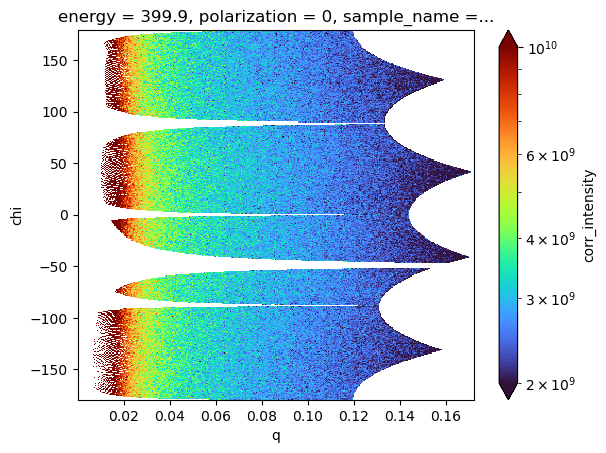

In [56]:
polar_DS['corr_intensity'].sel(sample_name='PM6-Y6_CB', polarization=0).sel(energy=400,method='nearest').plot(cmap=cmap, norm=LogNorm(2e9,1e10))
plt.show()

In [77]:
sorted(selected_samples)

['PM6-Y6BO_CB',
 'PM6-Y6BO_CF',
 'PM6-Y6BO_CFCN',
 'PM6-Y6_CB',
 'PM6-Y6_CBCN',
 'PM6-Y6_CF',
 'PM6-Y6_CFCN',
 'PM6-Y7BO_CB',
 'PM6-Y7BO_CBCN',
 'PM6-Y7BO_CF',
 'PM6-Y7BO_CFCN',
 'PM6-Y7_CB',
 'PM6-Y7_CBCN',
 'PM6-Y7_CF',
 'PM6-Y7_CFCN',
 'Y6BO_CB_2500',
 'Y6BO_CB_3000',
 'Y6BO_CF_2500',
 'Y6_CB_2000',
 'Y6_CB_2000_1',
 'Y6_CB_2500',
 'Y6_CB_3000',
 'Y6_CFCN',
 'Y6_CF_2000',
 'Y6_CF_2500',
 'Y7BO_CBCN',
 'Y7BO_CB_2000',
 'Y7BO_CB_2500',
 'Y7BO_CB_3000',
 'Y7BO_CF_2000',
 'Y7BO_CF_2500',
 'Y7BO_CF_3000',
 'Y7_CF_2000',
 'Y7_CF_2500',
 'Y7_CF_3000']

In [61]:
trmsn90_bkgs = []

for sample_name in tqdm(selected_samples):  
    trmsn90_samp_DA = trmsn90_DA.sel(sample_name=(sample_name.replace('_1','')+'_rot')).drop_vars(['sample_id', 'sample_name', 'theta', 'scan_id'])
    trmsn90_samp_DA = trmsn90_samp_DA.expand_dims({'sample_name':[sample_name]})
    trmsn90_bkgs.append(trmsn90_samp_DA)

trmsn90_bkgs_DA = xr.concat(trmsn90_bkgs, dim='sample_name')
trmsn90_bkgs_DA

  0%|          | 0/35 [00:00<?, ?it/s]

<xarray.DataArray 'pre_corr_trmsn' (sample_name: 35, energy: 57)>
dask.array<concatenate, shape=(35, 57), dtype=float64, chunksize=(1, 57), chunktype=numpy.ndarray>
Coordinates:
  * sample_name  (sample_name) object 'Y6_CB_2500' ... 'Y6_CB_2000_1'
  * energy       (energy) float64 380.0 382.9 385.6 388.5 ... 434.5 437.2 440.0

In [81]:
sorted(rsoxs_datasets['polar_nitrogen'].sample_name.values[:])

['BareSiN_1mm',
 'BareSiN_1mm_1',
 'BareSiN_1mm_2',
 'BareSiN_1p5mm',
 'PM6-Y6BO_CB',
 'PM6-Y6BO_CF',
 'PM6-Y6BO_CFCN',
 'PM6-Y6_CB',
 'PM6-Y6_CBCN',
 'PM6-Y6_CF',
 'PM6-Y6_CFCN',
 'PM6-Y7BO_CB',
 'PM6-Y7BO_CBCN',
 'PM6-Y7BO_CF',
 'PM6-Y7BO_CFCN',
 'PM6-Y7_CB',
 'PM6-Y7_CBCN',
 'PM6-Y7_CF',
 'PM6-Y7_CFCN',
 'Y6BO_CBCN',
 'Y6BO_CB_2500',
 'Y6BO_CB_3000',
 'Y6BO_CFCN',
 'Y6BO_CF_2500',
 'Y6_CBCN',
 'Y6_CB_2000',
 'Y6_CB_2000_1',
 'Y6_CB_2500',
 'Y6_CB_3000',
 'Y6_CFCN',
 'Y6_CF_2000',
 'Y6_CF_2500',
 'Y7BO_CBCN',
 'Y7BO_CB_2000',
 'Y7BO_CB_2500',
 'Y7BO_CB_3000',
 'Y7BO_CFCN',
 'Y7BO_CF_2000',
 'Y7BO_CF_2500',
 'Y7BO_CF_3000',
 'Y7_CBCN',
 'Y7_CB_2000',
 'Y7_CB_2000_1',
 'Y7_CFCN',
 'Y7_CF_2000',
 'Y7_CF_2500',
 'Y7_CF_3000']

In [84]:
sample_name = 'BareSiN_1mm'

pol_paras = []
pol_perps = []
for pol in [0, 90]:
    para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
    pol_paras.append(para_DA)
    pol_perps.append(perp_DA)


pol_paras[0] = pol_paras[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
pol_paras[1] = pol_paras[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
pol_perps[0] = pol_perps[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})
pol_perps[1] = pol_perps[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

pol_paras[0] = pol_paras[0].interp({'chi': pol_paras[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
pol_perps[0] = pol_perps[0].interp({'chi': pol_perps[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

sin_para_DA = (pol_paras[0] + pol_paras[1])/2
sin_perp_DA = (pol_perps[0] + pol_perps[1])/2

sin_para_DA = sin_para_DA.assign_coords({'polarization':'avg'})
sin_perp_DA = sin_perp_DA.assign_coords({'polarization':'avg'})

sin_para_DA = sin_para_DA.interpolate_na(dim='q')
sin_perp_DA = sin_perp_DA.interpolate_na(dim='q')

In [108]:
manual_scale_factors_v1 = {
    'PM6-Y6_CB': 0.7,
    'PM6-Y6_CBCN': 0.75,
    'PM6-Y6_CF': 0.5,
    'PM6-Y6_CFCN': 0.5,
    'PM6-Y6BO_CB': 0.65,
    'PM6-Y6BO_CF': 0.4,
    'PM6-Y6BO_CFCN': 0.65,
    'PM6-Y7_CB': 0.8,
    'PM6-Y7_CBCN': 0.8,
    'PM6-Y7_CF': 0.45,
    'PM6-Y7_CFCN': 0.5,
    'PM6-Y7BO_CB': 0.65,
    'PM6-Y7BO_CBCN': 0.7,
    'PM6-Y7BO_CF': 0.45,
    'PM6-Y7BO_CFCN': 0.62,
    'Y6BO_CB_2500': 0.63,
    'Y6BO_CB_3000': 2,
    'Y6BO_CF_2500': 2,
    'Y6_CB_2000_1': 0.63,
    'Y6_CB_2000': 0.72,
    'Y6_CB_2500': 0.6,
    'Y6_CB_3000': 0.7,
    'Y6_CF_2000': 0.5,
    'Y6_CF_2500': 0.45,
    'Y6_CFCN': 0.65,
    'Y6BO_CB_2500': 0.8,
    'Y6BO_CB_3000': 0.45,
    'Y6BO_CF_2500': 0.45,
    'Y7BO_CBCN': 0.8,
    'Y7BO_CB_2000': 0.5,
    'Y7BO_CB_2500': 0.5,
    'Y7BO_CB_3000': 0.5,
    'Y7BO_CF_2000': 0.55,
    'Y7BO_CF_2500': 0.55,
    'Y7BO_CF_3000': 0.55,
    'Y7_CF_2000': 0.8,
    'Y7_CF_2500': 0.7,
    'Y7_CF_3000': 0.8,
}

len(manual_scale_factors_v1)

35

In [110]:
manual_scale_factors_v2 = {
    'PM6-Y6_CB': 0.7,
    'PM6-Y6_CBCN': 0.75,
    'PM6-Y6_CF': 0.5,
    'PM6-Y6_CFCN': 0.5,
    'PM6-Y6BO_CB': 0.65,
    'PM6-Y6BO_CF': 0.3,
    'PM6-Y6BO_CFCN': 0.65,
    'PM6-Y7_CB': 0.8,
    'PM6-Y7_CBCN': 0.8,
    'PM6-Y7_CF': 0.4,
    'PM6-Y7_CFCN': 0.5,
    'PM6-Y7BO_CB': 0.65,
    'PM6-Y7BO_CBCN': 0.73,
    'PM6-Y7BO_CF': 0.35,
    'PM6-Y7BO_CFCN': 0.62,
    'Y6BO_CB_2500': 0.63,
    'Y6BO_CB_3000': 2,
    'Y6BO_CF_2500': 2,
    'Y6_CB_2000_1': 0.63,
    'Y6_CB_2000': 0.76,
    'Y6_CB_2500': 0.6,
    'Y6_CB_3000': 0.73,
    'Y6_CF_2000': 0.5,
    'Y6_CF_2500': 0.45,
    'Y6_CFCN': 0.65,
    'Y6BO_CB_2500': 0.8,
    'Y6BO_CB_3000': 0.45,
    'Y6BO_CF_2500': 0.45,
    'Y7BO_CBCN': 0.9,
    'Y7BO_CB_2000': 0.5,
    'Y7BO_CB_2500': 0.5,
    'Y7BO_CB_3000': 0.5,
    'Y7BO_CF_2000': 0.5,
    'Y7BO_CF_2500': 0.55,
    'Y7BO_CF_3000': 0.55,
    'Y7_CF_2000': 0.9,
    'Y7_CF_2500': 0.75,
    'Y7_CF_3000': 0.87,
}

len(manual_scale_factors_v2)

35

In [111]:
# make selection
edge = 'nitrogen'
intensity_type = 'corr'
qlims = (8e-3, None)
chi_width = 90

for sample_name in tqdm(sorted(selected_samples)):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6_CBCN', 'PM6-Y6_CF', 'PM6-Y6_CFCN']):
# for sample_name in tqdm(sorted(rsoxs_datasets['polar_nitrogen'].sample_name.values[:])):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6BO_CB', 'PM6-Y6BO_CF']):
    # for pol in [0]:
    #     para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
   
    pol_paras = []
    pol_perps = []
    for pol in [0, 90]:
        para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
        pol_paras.append(para_DA)
        pol_perps.append(perp_DA)


    pol_paras[0] = pol_paras[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_paras[1] = pol_paras[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})
    pol_perps[1] = pol_perps[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    pol_paras[0] = pol_paras[0].interp({'chi': pol_paras[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].interp({'chi': pol_perps[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    para_DA = (pol_paras[0] + pol_paras[1])/2
    perp_DA = (pol_perps[0] + pol_perps[1])/2

    para_DA = para_DA.assign_coords({'polarization':'avg'})
    perp_DA = perp_DA.assign_coords({'polarization':'avg'})

    para_DA = para_DA.interpolate_na(dim='q')
    perp_DA = perp_DA.interpolate_na(dim='q')

    pol = str(para_DA.polarization.values) 
    
    # Subtract bare SiN:
    samp_para_factor = float(para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    samp_perp_factor = float(perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
    sin_para_factor = float(sin_para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    sin_perp_factor = float(sin_perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
    manual_scale_factor = manual_scale_factors_v2[sample_name]
        
    para_DA = para_DA - (manual_scale_factor * ((sin_para_DA/sin_para_factor) * samp_para_factor))
    perp_DA = perp_DA - (manual_scale_factor * ((sin_perp_DA/sin_perp_factor) * samp_perp_factor))
    
    
#     # Fl correction?
#     # scale_factor = float(para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').integrate('q'))
#     scale_factor = 1e9
#     manual_scale_factor = 2
#     trmsn90_corr = (manual_scale_factor * scale_factor * trmsn90_bkgs_DA.sel(sample_name=sample_name.replace('_rot','')))
    
#     para_DA = para_DA - trmsn90_corr
#     perp_DA = perp_DA - trmsn90_corr
        
    # Plot
    # energies = para_DA.energy.sel(energy=[275, 283, 284, 284.4, 284.8, 285.2, 285.6, 286.2, 287, 288, 300, 305], method='nearest').data
    energies = para_DA.energy.sel(energy=[385, 396, 397, 398, 399, 399.6, 400.4, 400.8, 401.4, 402, 410, 420], method='nearest').data

    cmap = plt.cm.turbo.copy()
    colors = cmap(np.linspace(0, 1, len(energies)))

    fig, axs = plt.subplots(ncols=2,figsize=(8,5), tight_layout=True)

    qmin = qlims[0]
    qmax = qlims[1]

    for j, energy in enumerate(energies):
        (para_DA.sel(q=slice(qmin, qmax), energy=energy).mean('chi')
     .plot.line(ax=axs[0], color=colors[j], yscale='log', xscale='log', label=energy))
        (perp_DA.sel(q=slice(qmin, qmax), energy=energy).mean('chi')
         .plot.line(ax=axs[1], color=colors[j], yscale='log', xscale='log', label=energy))

    # fig.suptitle(f'IvsQ, {pol}° pol, 90° chi width: {sample_name}', x=0.47)
    fig.suptitle(f'IvsQ (Bare SiN Subracted (C={manual_scale_factor})), {pol}° pol, 90° chi width: {sample_name}', x=0.47)

    axs[0].set(title=f'Parallel to E$_p$', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
    axs[0].set_ylim(bottom=1e8)
    axs[1].set(title=f'Perpendicular to E$_p$', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
    axs[1].set_ylim(bottom=1e8)
    axs[1].legend(title='Energy [eV]', loc=(1.05,0.1))

    savePath = plotsPath.joinpath('nitrogen','sin_sub_nitrogen_backgrounds', f'manual_scale_factor_dict-v2')
    savePath.mkdir(parents=True, exist_ok=True)
    
    fig.savefig(savePath.joinpath(f'{sample_name}_chiWidth-{chi_width}deg_q{qmin}-{qmax}_pol{pol}deg.png'), dpi=120)

    # plt.show()
    plt.close('all')

  0%|          | 0/35 [00:00<?, ?it/s]

In [74]:
# make selection
edge = 'nitrogen'
intensity_type = 'corr'
qlims = (None, None)
chi_width = 90


# sin_DS = full_DS.sel(sample_name='BareSiN_1mm_1')


for sample_name in tqdm(full_DS.sample_name.values[:]):
    samp_DS = full_DS.sel(sample_name=[sample_name])
    constants = 0.85 * (samp_DS.sel(q=slice(0.06,0.1), energy=slice(420,430)).mean('q').mean('energy')) / (sin_DS.sel(q=slice(0.06,0.1), energy=slice(420,430)).mean('q').mean('energy'))

    DS = samp_DS - (constants * sin_DS)    

    # DS = full_DS.copy()
    
    for pol in [0, 90]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, intensity_type, pol, qlims, chi_width) 
        
        # energies = para_DA.energy.sel(energy=slice(398.4, 401.5)).data
        # energies = para_DA.energy.sel(energy=slice(390, 404)).data
        energies = para_DA.energy.sel(energy=[390, 398.8, 399.8, 401.1, 410, 430], method='nearest').data

        # # Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
        # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=energies[0], vmax=energies[-1]))
        # cax = ax.inset_axes([1.03, 0, 0.03, 1])
        # cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        # cbar.set_label(label=f'Time [seconds]', labelpad=14)
        # cbar.set_ticks(np.round(np.linspace(energies[0], energies[-1], len(energies)), 2))

        fig, axs = plt.subplots(ncols=2,figsize=(8,5), tight_layout=True)
        colors = cmap(np.linspace(0, 1, len(energies)))
        
        qmin = 9e-3
        qmax = None

        for j, energy in enumerate(energies):
            (para_DA.sel(q=slice(qmin, qmax), energy=energy).mean('chi')
             .plot.line(ax=axs[0], color=colors[j], yscale='log', xscale='log', label=energy))
            (perp_DA.sel(q=slice(qmin, qmax), energy=energy).mean('chi')
             .plot.line(ax=axs[1], color=colors[j], yscale='log', xscale='log', label=energy))

        # fig.suptitle(f'Linecuts: {sample_name}')
        fig.suptitle(f'Linecuts, Bare SiN Subtracted: {sample_name}')
        # fig.suptitle(f'Linecuts, Bare SiN & Flourescence Subtracted: {sample_name}')

        axs[0].set(ylim=(1e7, None), title=f'Para, Polarization = {pol}°, chi width = {chi_width}', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].set(ylim=(1e7, None), title=f'Perp, Polarization = {pol}°, chi width = {chi_width}', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')

        axs[0].legend(title='Energy [eV]')
        axs[1].legend(title='Energy [eV]')
        
        # fig.savefig(plotsPath.joinpath('selected_linecuts_nitrogen_v1', 
        #     f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_q{qmin}-{qmax}_pol{pol}deg.png'), dpi=120)
        # fig.savefig(plotsPath.joinpath('selected_linecuts_nitrogen_v1', 
        #     f'sin-sub_{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_q{qmin}-{qmax}_pol{pol}deg.png'), dpi=120)        

        # plt.show()
        plt.close('all')

  0%|          | 0/47 [00:00<?, ?it/s]

## Anisotropy Ratio Plots

### 1. 2D AR Maps

In [140]:
# make selection
# sample_name = 'Y6_CB_2500'
edge = 'nitrogen'
intensity_type = 'corr'
# pol = 90
qlims = (9.5e-3, None)
chi_width = 90
energy_min = 395
energy_max = 407

# for sample_name in selected_samples:
for sample_name in tqdm(sorted(selected_samples)):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6_CBCN', 'PM6-Y6_CF', 'PM6-Y6_CFCN']):
# for sample_name in tqdm(sorted(rsoxs_datasets['polar_nitrogen'].sample_name.values[:])):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6BO_CB', 'PM6-Y6BO_CF']):
    # for pol in [0]:
    #     para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
   
    pol_paras = []
    pol_perps = []
    for pol in [0, 90]:
        para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
        pol_paras.append(para_DA)
        pol_perps.append(perp_DA)


    pol_paras[0] = pol_paras[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_paras[1] = pol_paras[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})
    pol_perps[1] = pol_perps[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    pol_paras[0] = pol_paras[0].interp({'chi': pol_paras[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].interp({'chi': pol_perps[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    para_DA = (pol_paras[0] + pol_paras[1])/2
    perp_DA = (pol_perps[0] + pol_perps[1])/2

    para_DA = para_DA.assign_coords({'polarization':'avg'})
    perp_DA = perp_DA.assign_coords({'polarization':'avg'})

    para_DA = para_DA.interpolate_na(dim='q')
    perp_DA = perp_DA.interpolate_na(dim='q')

    pol = str(para_DA.polarization.values) 
    
#     # Subtract bare SiN:
#     samp_para_factor = float(para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
#     samp_perp_factor = float(perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
#     sin_para_factor = float(sin_para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
#     sin_perp_factor = float(sin_perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
#     manual_scale_factor = manual_scale_factors_v2[sample_name]
        
#     para_DA = para_DA - (manual_scale_factor * ((sin_para_DA/sin_para_factor) * samp_para_factor))
#     perp_DA = perp_DA - (manual_scale_factor * ((sin_perp_DA/sin_perp_factor) * samp_perp_factor))

    # Select AR data
    ar_DA = (para_DA.mean('chi') - perp_DA.mean('chi')) / (para_DA.mean('chi') + perp_DA.mean('chi'))

    # Plot
    vlim = 0.2
    ax = ar_DA.sel(energy=slice(energy_min,energy_max)).plot(figsize=(8,5), norm=plt.Normalize(-vlim, vlim))
    # ax = ar_DA.sel(energy=slice(energy_min,energy_max)).plot(figsize=(8,5))

    ax.figure.suptitle('Anisotropy Ratio (AR) Map', fontsize=14, x=0.43)
    ax.axes.set(xscale='log', title=f'{sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', ylabel='Photon Energy [eV]', xlabel='q [$Å^{-1}$]')
    ax.colorbar.set_label('AR [arb. units]', rotation=270, labelpad=12)


    ax.figure.savefig(plotsPath.joinpath('nitrogen','ar_maps_nitrogen_v2', 
        f'vset_{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_q-{qlims[0]}-{qlims[1]}_energy{energy_min}-{energy_max}_pol{pol}deg.png'), 
                      dpi=120)

    # plt.show()
    plt.close('all')

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
ARvsQ_avg.hvplot.line(groupby="energy")

### 2. 1D AR Maps

In [130]:
sorted(energies, reverse=True)

[402.0, 401.45, 400.7, 400.4, 399.65, 399.1, 398.05, 397.0, 397.0, 385.65]

In [138]:
# make selection
# sample_name = 'Y6_CB_2500'
edge = 'nitrogen'
intensity_type = 'corr'
# pol = 90
qlims = (7.5e-3, 0.105)
chi_width = 90
energy_min = 282
energy_max = 292

for sample_name in tqdm(sorted(selected_samples)):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6_CBCN', 'PM6-Y6_CF', 'PM6-Y6_CFCN']):
# for sample_name in tqdm(sorted(rsoxs_datasets['polar_nitrogen'].sample_name.values[:])):
# for sample_name in tqdm(['PM6-Y6_CB', 'PM6-Y6BO_CB', 'PM6-Y6BO_CF']):
    # for pol in [0]:
    #     para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
   
    pol_paras = []
    pol_perps = []
    for pol in [0, 90]:
        para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width) 
        pol_paras.append(para_DA)
        pol_perps.append(perp_DA)


    pol_paras[0] = pol_paras[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_paras[1] = pol_paras[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})
    pol_perps[1] = pol_perps[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    pol_paras[0] = pol_paras[0].interp({'chi': pol_paras[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].interp({'chi': pol_perps[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    para_DA = (pol_paras[0] + pol_paras[1])/2
    perp_DA = (pol_perps[0] + pol_perps[1])/2

    para_DA = para_DA.assign_coords({'polarization':'avg'})
    perp_DA = perp_DA.assign_coords({'polarization':'avg'})

    para_DA = para_DA.interpolate_na(dim='q')
    perp_DA = perp_DA.interpolate_na(dim='q')

    pol = str(para_DA.polarization.values) 
    
#     # Subtract bare SiN:
#     samp_para_factor = float(para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
#     samp_perp_factor = float(perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
#     sin_para_factor = float(sin_para_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
#     sin_perp_factor = float(sin_perp_DA.sel(energy=slice(396,405), q=slice(3e-2,8e-2)).mean('chi').mean('energy').mean('q'))
    
#     manual_scale_factor = manual_scale_factors_v2[sample_name]
        
#     para_DA = para_DA - (manual_scale_factor * ((sin_para_DA/sin_para_factor) * samp_para_factor))
#     perp_DA = perp_DA - (manual_scale_factor * ((sin_perp_DA/sin_perp_factor) * samp_perp_factor))
    
    
    # Select AR data
    ar_DA = (para_DA.mean('chi') - perp_DA.mean('chi')) / (para_DA.mean('chi') + perp_DA.mean('chi'))
    energies = para_DA.energy.sel(energy=[385, 396, 397, 398, 399, 399.6, 400.4, 400.8, 401.4, 402, 410, 420], method='nearest').data
    # energies = para_DA.energy.sel(energy=[385, 396, 397, 398, 399, 399.6, 400.4, 400.8, 401.4, 402], method='nearest').data

    # Plot   
    cmap = plt.cm.turbo.copy()
    colors = cmap(np.linspace(0, 1, len(energies)))        

    # # Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=energies[0], vmax=energies[-1]))
    # cax = ax.inset_axes([1.03, 0, 0.03, 1])
    # cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    # cbar.set_label(label=f'Time [seconds]', labelpad=14)
    # cbar.set_ticks(np.round(np.linspace(energies[0], energies[-1], len(energies)), 2))

    fig, ax = plt.subplots(tight_layout=True, figsize=(6,4), dpi=120)

    for j, energy in enumerate(energies):
        (ar_DA.sel(energy=energy).plot.line(ax=ax, color=colors[j], label=energy, xscale='log'))

    fig.suptitle(f'Anisotropy Ratio Linecuts: {sample_name}', x=0.46)

    ax.set(title=f'Chi width = {chi_width}°, Pol = {pol}°', ylim=(-0.3, 0.3), ylabel='AR [arb. units]', xlabel='Q [$Å^{-1}$]')
    ax.legend(title='Energy [eV]', loc=(1.03,0.02))


    fig.savefig(plotsPath.joinpath('nitrogen', 'selected_ar_linecuts_nitrogen_v2', 
        f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_q-full_pol{pol}deg.png'), dpi=120)

    # plt.show()
    plt.close('all')

  0%|          | 0/35 [00:00<?, ?it/s]

## Loop for saving many plots

In [ ]:
rsoxs_datasets['polar_oxygen']

In [ ]:
# make selection
edge = 'oxygen'
intensity_type = 'corr'
qlims = (0.01, 0.08)
chi_width = 30
energy_min = 525
energy_max = 545
cmin = 5e8
cmax = 5e10

for sample_name in tqdm(rsoxs_datasets[f'polar_{edge}'].sample_name.data):
    for pol in [0, 90]:
        ### Select para & perp DataArrays
        para_DA, perp_DA = make_para_perp_DAs(rsoxs_datasets, sample_name, edge, intensity_type, pol, qlims, chi_width)  
        
        ### ISI:
        # Slice ISI data
        para_ISI = para_DA.interpolate_na(dim='q').mean('chi').sum('q')
        perp_ISI = perp_DA.interpolate_na(dim='q').mean('chi').sum('q')
        
        # Plot
        fig, ax = plt.subplots()
        para_ISI.sel(energy=slice(energy_min,energy_max)).plot.line(ax=ax, label='para', yscale='log')
        perp_ISI.sel(energy=slice(energy_min,energy_max)).plot.line(ax=ax, label='perp', yscale='log')
        # para_ISI.plot.line(ax=ax, label='para', yscale='log')
        # perp_ISI.plot.line(ax=ax, label='perp', yscale='log')        
        fig.suptitle('Integrated Scattering Intensity (ISI)', fontsize=14)
        ax.set(title=f'{sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', xlabel='Photon Energy [eV]', ylabel='Double-Norm-Corrected Intensity [arb. units]')
        ax.legend()
        fig.savefig(plotsPath.joinpath('isi_oxygen_v1', f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)
        # plt.show()
        plt.close('all')
        
        ### Linecut Maps:
        fig, axs = plt.subplots(1, 2, figsize=(11,5))

        para_DA.mean('chi').sel(energy=slice(energy_min,energy_max)).plot(ax=axs[0], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)
        perp_DA.mean('chi').sel(energy=slice(energy_min,energy_max)).plot(ax=axs[1], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(cmin, cmax)) # Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
        cax = axs[1].inset_axes([1.03, 0, 0.05, 1])
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_label(label='Intensity [arb. units]', labelpad=12)
        fig.suptitle(f'Linecut Maps: {sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', fontsize=14)
        fig.set(tight_layout=True)
        axs[0].set(title='Parallel to $E_p$', ylabel='Photon energy [eV]', xlabel='q [$Å^{-1}$]')
        axs[1].set(title='Perpendicular to $E_p$ ', ylabel=None, xlabel='q [$Å^{-1}$]')
        fig.savefig(plotsPath.joinpath('linecut_maps_oxygen_v1', f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)
        # plt.show()
        plt.close('all')

        ### AR Maps:
        # Select AR data
        ar_DA = (para_DA.mean('chi') - perp_DA.mean('chi')) / (para_DA.mean('chi') + perp_DA.mean('chi'))

        if para_DA.sample_name=='BareSiN':
            bareSiN_ar_DA = ar_DA.copy()
            
        # # Subtract AR from SiN:
        # ar_DA = ar_DA - bareSiN_ar_DA

        # Plot
        ax = ar_DA.sel(energy=slice(energy_min,energy_max)).plot(figsize=(8,5), norm=plt.Normalize(-0.6, 0.6))
        ax.figure.suptitle('Anisotropy Ratio (AR) Map', fontsize=14, x=0.43)
        ax.axes.set(title=f'{sample_name}, Polarization = {pol}°, Chi Width = {chi_width}°', ylabel='Photon Energy [eV]', xlabel='q [$Å^{-1}$]')
        ax.colorbar.set_label('AR [arb. units]', rotation=270, labelpad=12)
        ax.figure.savefig(plotsPath.joinpath('ar_maps_oxygen_v1', f'{sample_name}_{edge}_{intensity_type}_chiWidth-{chi_width}deg_pol{pol}deg.png'), dpi=120)
        # plt.show()
        plt.close('all')

## Incorporating simulation output
old and incomplete

In [ ]:
import h5py

In [ ]:
whos PosixPath

In [ ]:
simsPath = rootPath.joinpath('imgs_analysis/sim_runs')

In [ ]:
[f.name for f in simPath.iterdir()]

In [ ]:
simPath = simsPath.joinpath('D1.0_a1.0_eps1.0_250pix_375size_0.5m_600steps_1')
h5path = simPath.joinpath('HDF5')
h5list = sorted(h5path.glob('E*h5'))

In [ ]:
def print_key(f, key):
    try:
        keys2 = f[key].keys()
        for key2 in keys2:
            new_key = key + '/' + key2
            print_key(f, new_key)
    except AttributeError:
        print(key)

with h5py.File(h5list[0],'r') as f:
    for key in f.keys():
        print_key(f, key)

#### The scattering pattern is contained within 'K0/projection.' If you simulated multiple incident angles there would be additional 'K#' keys. KIDList contains the vector values for each of the incident angles (propagation direction).

#### Instantiate the PyHyperScattering loader and integrator

In [ ]:
load = phs.load.cyrsoxsLoader(use_chunked_loading=True)
integ = phs.integrate.WPIntegrator(force_np_backend=True) # avoiding gpu backend for this tutorial

In [ ]:
raw = load.loadDirectory(simPath)

In [ ]:
raw

In [ ]:
remeshed = integ.integrateImageStack(raw)

In [ ]:
remeshed

In [ ]:
remeshed.sel(energy=285.1).plot()

In [ ]:
# c = cm.jet(np.linspace(0,1,len(remeshed)))

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=140,constrained_layout=True)
raw.sel(energy=275).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[0],add_colorbar=False)
raw.sel(energy=285).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[1],add_colorbar=False)
raw.sel(energy=295).plot(norm=LogNorm(1e-7,1),cmap='terrain',ax=ax[2])

[{axes.set_xlim(-0.1,0.1),axes.set_ylim(-0.1,0.1)} for axes in ax]
plt.show()

In [ ]:
loaded_rsoxs.build_tiff_stack??